# 7章　ニューラルネットワーク・ディープラーニング

1. 機械学習の種類３つ
2. 教師あり学習の基本
3. 単層パーセプトロン、ニューラルネットワーク、ディープラーニングの違い

# 7.1 ニューロンモデル

## 7.1.1 神経細胞
### 神経細胞が電気信号を送る仕組み
脳の中などの神経細胞は、軸索というケーブル（木の枝）のようなものでつながっていて、軸索からシナプスという継ぎ目を伝って電気信号を別の神経細胞に送る。
ある神経細胞に送られてきた電気が細胞内に膜電位（細胞内の電位）として溜まっていき、一定値を超えるとまた次の神経細胞に電気が送られる。

### シナプスの仕組み
どれだけの電気信号を送るかは、シナプス伝達強度というもので決まる。

- シナプス伝達強度が機械学習でいう重み
- 神経細胞一つ一つが機械学習でいうノード

## 7.1.2 ニューロンモデル

説明変数２つあるとして、それらに重みをかけて総和を取り、0〜1の間の値で出力するニューロンモデルを考える。

説明変数が2つあるから、入力総和を図示すると平面になる。\
これをシグモイド関数に通すから出力が0〜1に押しつぶされたような形になる。

範囲　6.3.3 - 7.1.2 OpenCV C-1 - C-2 \
担当　7.0 - 7.1.1とOpenCV C-1

8/8 c-3 - c-5

# 7.2 ニューラルネットワークモデル

## 7.2.1 2層フィードフォワードニューラルネット

### インデックスの表現方法
i番目の入力からj番目のニューロンのへの重みを$w_{ji}$と書く

### 活性化関数
入力総和から、別の値で出力をする際に使う関数のこと

入力総和があるニューロンに届き次のニューロンに出力する前に通す関数のこと

例：シグモイド関数、softmax関数、尤度関数

## 7.2.2 2層フィードフォワードニューラルネットの実装

まずは使用するデータを作成

In [34]:
import numpy as np
# データ生成
np.random.seed(seed=1)
N = 200                                 # サンプル数
K = 3                                   # クラス数
T = np.zeros((N, 3), dtype=np.uint8)
X = np.zeros((N, 2))
X0_min, X0_max = -3, 3
X1_min, X1_max = -3, 3

prm_mu = np.array([[-0.5, -0.5], [0.5, 1.0], [1, -0.5]])    # 平均値
prm_sig = np.array([[0.7, 0.7], [0.8, 0.3], [0.3, 0.8]])    # 分散
prm_pi = np.array([0.4, 0.8, 1])                            # 各クラスの割合

for n in range(N):
    r = np.random.rand()
    # 3クラス用の目標データTを生成
    for k in range(K):
        if r < prm_pi[k]:
            T[n, k] = 1
            break
    # Tに対して入力データXを生成
    for k in range(2):      # 2次元データなので2回ループ
        X[n, k] = \
            (np.random.randn() * prm_sig[T[n, :] == 1, k] \
            + prm_mu[T[n, :] == 1, k])

データの前処理を行う

In [35]:
# 訓練データとテストデータに分割
TrainingRatio = 0.5
N_training = int(N * TrainingRatio)
X_train = X[:N_training, :]
X_test = X[N_training:, :]
T_train = T[:N_training, :]
T_test = T[N_training:, :]

# データの保存
np.savez(
    'ch7_data.npz',
    X_train=X_train, T_train=T_train, X_test=X_test, T_test=T_test,
    X0_min=X0_min, X0_max=X0_max, X1_min=X1_min, X1_max=X1_max
)

データの表示

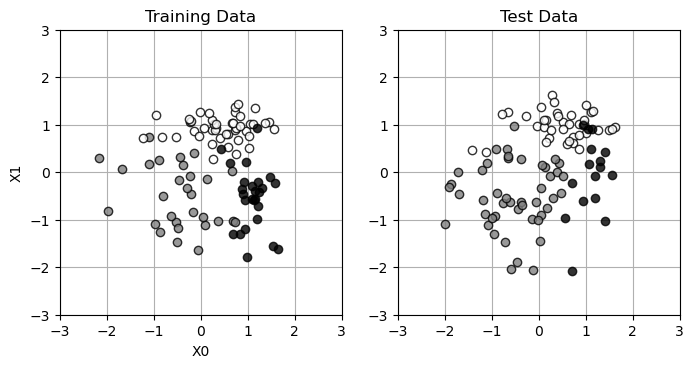

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt

# データの表示
def show_data(x, t):
    K = t.shape[1]      # クラス数を取得
    col = ['gray', 'white', 'black']
    for k in range(K):
        plt.plot(
            x[t[:, k] == 1, 0], x[t[:, k] == 1, 1],         # クラスkのxをプロット
            linestyle='none', markeredgecolor='black',
            marker='o', color=col[k], alpha=0.8
        )
    plt.xlim(X0_min, X0_max)
    plt.ylim(X1_min, X1_max)

# メイン
plt.figure(figsize=(8, 3.7))
# 訓練データを表示
plt.subplot(1, 2, 1)
show_data(X_train, T_train)
plt.title('Training Data')
plt.xlabel('X0')
plt.ylabel('X1')
plt.grid()
# テストデータ表示
plt.subplot(1, 2, 2)
show_data(X_test, T_test)
plt.title('Test Data')
plt.grid()
plt.show()

このデータを、2つの説明変数（＋ダミー変数）を入力から層2つを介して分類予測を出力するモデルを構築する。

In [37]:
# シグモイド関数
def sigmoid(a):
    y = 1 / (1 + np.exp(-a))
    return y

In [38]:
# ネットワーク
def FNN(wv, M, K, x):       # M:中間層の数, K:出力層の数
    N, D = x.shape  # 入力次元 Dは説明変数の数
    w = wv[:M * (D + 1)]    # 中間層ニューロンへの重み
    w = w.reshape(M, (D + 1))
    v = wv[M * (D + 1):]    # 出力層ニューロンへの重み
    v = v.reshape((K, M + 1))
    b = np.zeros((N, M + 1))    # 中間層ニューロンの入力総和の計算用
    z = np.zeros((N, M + 1))    # 中間層ニューロンの出力の計算用
    a = np.zeros((N, K))        # 出力層ニューロンの入力総和の計算用
    y = np.zeros((N, K))        # 出力層ニューロンの出力の計算用
    for n in range(N):
        # 中間層の計算
        for m in range(M):
            # x[n, :]の末尾にダミーの入力値「1」を追加
            x_add1 = np.r_[x[n, :], 1]  # np.r_[]は配列を結合する
            b[n, m] = w[m, :] @ x_add1
            z[n, m] = sigmoid(b[n, m])
        # 出力層の計算
        z[n, M] = 1     # ダミーニューロン
        u = 0
        for k in range(K):
            a[n, k] = v[k, :] @ z[n, :]
            u = u + np.exp(a[n, k])
        for k in range(K):
            y[n, k] = np.exp(a[n, k]) / u
    return y, a, z, b

In [39]:
# # テスト
# wv = np.ones(15)
# M, K = 2, 3
# y, a, z, b = FNN(wv, M, K, X_train[:2, :])
# print('y =\n', np.round(y, 3))
# print('a =\n', np.round(a, 3))
# print('z =\n', np.round(z, 3))
# print('b =\n', np.round(b, 3))
# print('y.reahpe(-1) =\n', y.reshape(-1))

# 7.2.3 数値微分法

学習則として勾配法を使う際に、[[誤差関数]]を各パラメータで偏微分するというような数式レベルの微分計算を真面目にしなくても、時間はかかるが微分値を求める方法

Kerasのようなディープラーニング用フレームワークにはほとんどこれが用いられている。

### 具体的な計算法
w地点における傾きを求めたい場合、
w地点の少し先のw+εの値と少し手前のw-εの値を、2εで割れば傾きの近似値が求められる \
+εと-εの二回計算しないといけないため、数式レベルの計算よりも時間がかかる。

3つに分類する問題を解いていく。
分類問題を扱うので、誤差関数には平均交差エントロピーを使う

In [40]:
def cee_FNN(wv, M, K, x, t):
    N, D = x.shape
    y, a, z, b = FNN(wv, M, K, x)
    # 平均交差エントロピー誤差(二重の和を内積により一気に計算)
    cee = -(t.reshape(-1) @ np.log(y.reshape(-1))) / N      # reshape(-1)は1次元配列に変換
    return cee

In [41]:
# # テスト
# wv = np.ones(15)
# M, K = 2, 3
# cee = cee_FNN(wv, M, K, X_train[:2, :], T_train[:2, :])
# print('cee =', cee)

平均交差エントロピーの数値微分

In [42]:
def dcee_FNN_num(wv, M, K, x, t):
    epsilon = 0.001
    dwv = np.zeros_like(wv)         # dwvと同じ形状の配列を生成
    # 数値微分処理
    for iwv in range(len(wv)):
        wv_shifted = wv.copy()
        wv_shifted[iwv] = wv[iwv] + epsilon
        mse1 = cee_FNN(wv_shifted, M, K, x, t)
        wv_shifted[iwv] = wv[iwv] + epsilon
        mse2 = cee_FNN(wv_shifted, M, K, x, t)
        dwv[iwv] = (mse2 - mse1) / (2 * epsilon)
    return dwv

dwvの棒グラフによる表示

numerical dwv
wv:
 [ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763 -2.3015387
  1.74481176 -0.7612069   0.3190391  -0.24937038  1.46210794 -2.06014071
 -0.3224172  -0.38405435  1.13376944]
dwv =
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


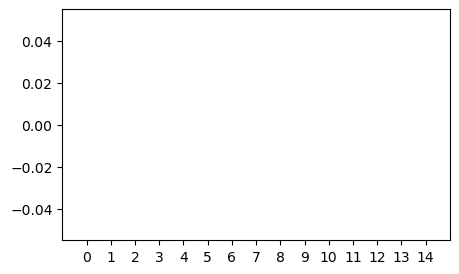

In [50]:
def show_dwv(dwv, D, M):
    v_start = M * (D + 1)       # vの開始インデックス
    v_end = dwv.shape[0] - 1    # vの終了インデックス
    plt.bar(    # dwの表示
        range(0, v_start), dwv[:v_start],
        color='black', align='center'
    )
    plt.bar(    # dvの表示
        range(v_start, v_end + 1), dwv[v_start:],
        color='cornflowerblue', align='center'
    )
    plt.xticks(range(0, v_end + 1))
    plt.xlim(-1, v_end + 1)

# テスト
D, M, K = 2, 2, 3
wv_n = M * (D + 1) + K * (M + 1)
np.random.seed(seed=1)
wv = np.random.normal(0.0, 1.0, wv_n)       # 平均0.0, 分散1.0のwv_n個の乱数
dwv = dcee_FNN_num(wv, M, K, X_train, T_train)
print('numerical dwv')
print('wv:\n', wv)
# print('X_train:\n', X_train)
# print('T_train:\n', T_train)
# print('X_test:\n', X_test)
# print('T_test:\n', T_test)
print('dwv =\n', np.round(dwv, 6))

# グラフ描画
plt.figure(figsize=(5, 3))
show_dwv(dwv, D, M)
plt.show()

# 7.2.4 数値微分法による勾配法

この数値微分を行う関数を使って、勾配法を適用してみる

今回のポイント
- 重みの初期値を入力
- テストデータも入力して、過学習が起きていないか確認
- tau_maxは学習ステップ数
- alphaは学習率
- 出力は最適化された（誤差の小さい重みwv）

数値微分を使った勾配法の学習モデルの実装

In [44]:
def fit_FNN_num(wv_init, M, K, x_train, t_train, x_test, t_test, tau_max, alpha):
    # 訓練データの誤差の履歴保存用
    cee_train_hist = np.zeros(tau_max)
    # テストデータの誤差の履歴保存用
    cee_test_hist = np.zeros(tau_max)
    # パラメータwvの履歴保存用
    wv_hist = np.zeros((tau_max, len(wv_init)))
    # パラメータの初期値をセットし、何も学習していないときの誤差を計算
    wv_hist[0, :] = wv_init
    cee_train_hist[0] = cee_FNN(wv_init, M, K, x_train, t_train)
    cee_test_hist[0] = cee_FNN(wv_init, M, K, x_test, t_test)
    # 勾配法
    for tau in range(tau_max - 1):
        dcee = dcee_FNN_num(wv_hist[tau, :], M, K, x_train, t_train)
        wv_hist[tau + 1, :] = wv_hist[tau, :] - alpha * dcee
        cee_train_hist[tau + 1] = cee_FNN(wv_hist[tau + 1, :], M, K, x_train, t_train)
        cee_test_hist[tau + 1] = cee_FNN(wv_hist[tau + 1, :], M, K, x_test, t_test)
    wv_final = wv_hist[-1, :]
    return wv_final, wv_hist, cee_train_hist, cee_test_hist

メイン処理　学習にかかった時間

In [45]:
import time

start_time = time.time()
D, M, K = 2, 2, 3                               # 入力次元, 中間層の数, 出力層の数
wv_n = M * (D + 1) + K * (M + 1)                # 中間層と出力層の重みの数
np.random.seed(seed=1)
wv_init = np.random.normal(0.0, 0.01, wv_n)     # 平均0.0, 分散0.01のwv_n個の乱数
tau_max = 1000                                  # 繰り返しの最大数
alpha = 0.1                                     # 学習率
# 勾配法でwvを最適化
wv, wv_hist, cee_train_hist, cee_test_hist = \
    fit_FNN_num(wv_init, M, K, X_train, T_train, X_test, T_test, tau_max, alpha)
# 計算時間の表示
calculation_time = time.time() - start_time
print('Calculation time:{0:.2f} sec'.format(calculation_time))

Calculation time:50.34 sec
time.time:{0:.2f} 1693290032.594238


学習誤差のグラフ表示

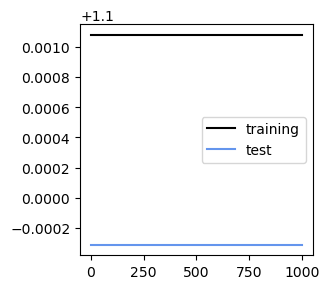

In [46]:
plt.figure(figsize=(3, 3))
plt.plot(cee_train_hist, 'black', label='training')
plt.plot(cee_test_hist, 'cornflowerblue', label='test')
plt.legend()
plt.show()

重みの時間発展の表示

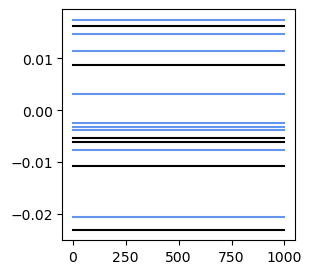

In [47]:
plt.figure(figsize=(3, 3))
v_start = M * (D + 1)           # vの開始インデックス
plt.plot(wv_hist[:, :v_start], 'black')
plt.plot(wv_hist[:, v_start:], 'cornflowerblue')
plt.show()

3つのクラス二分類する境界線を表示させる

xx0.shape:
 [[-3.         -2.89830508 -2.79661017 -2.69491525]
 [-3.         -2.89830508 -2.79661017 -2.69491525]
 [-3.         -2.89830508 -2.79661017 -2.69491525]
 [-3.         -2.89830508 -2.79661017 -2.69491525]]
xx1.shape:
 [[-3.         -3.         -3.         -3.        ]
 [-2.89830508 -2.89830508 -2.89830508 -2.89830508]
 [-2.79661017 -2.79661017 -2.79661017 -2.79661017]
 [-2.69491525 -2.69491525 -2.69491525 -2.69491525]]
x.shape:
 (3600, 2)


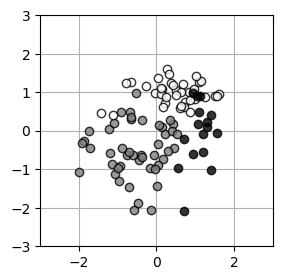

In [48]:
def show_FNN(wv, M, K):
    x0_n, x1_n = 60, 60      # 表示する格子点の数、解像度
    x0 = np.linspace(X0_min, X0_max, x0_n)
    x1 = np.linspace(X1_min, X1_max, x1_n)
    xx0, xx1 = np.meshgrid(x0, x1)
    # xx0とxx1を1次元配列に変換し,
    # それぞれを0列目と1列目に持つ2次元配列xを生成
    x = np.c_[xx0.reshape(-1), xx1.reshape(-1)]     # np.c_[]は配列を結合する
    print('xx0.shape:\n', xx0[:4, :4])
    print('xx1.shape:\n', xx1[:4, :4])
    print('x.shape:\n', x.shape)
    # 行列xに対するyを一度に計算
    y, a, z, b = FNN(wv, M, K, x)
    for ic in range(K):
        f = y[:, ic]
        f = f.reshape(x0_n, x1_n)
        f = f.T
        cont = plt.contour(xx0, xx1, f, levels=[0.8, 0.9], colors=['cornflowerblue', 'black'])
        cont.clabel(fmt='%.2f', fontsize=9)
    plt.xlim(X0_min, X0_max)
    plt.ylim(X1_min, X1_max)

# 境界線の表示
plt.figure(figsize=(3, 3))
show_data(X_test, T_test)
show_FNN(wv, M, K)
plt.grid()
plt.show()

担当7.2.4